# Project Computational Science

##### imports

In [51]:
from modules.hh_model import HodgkinHuxleyNeuron
from modules.layered_network import LayeredNetworkGraph

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from scipy.optimize import curve_fit

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

### Neuron

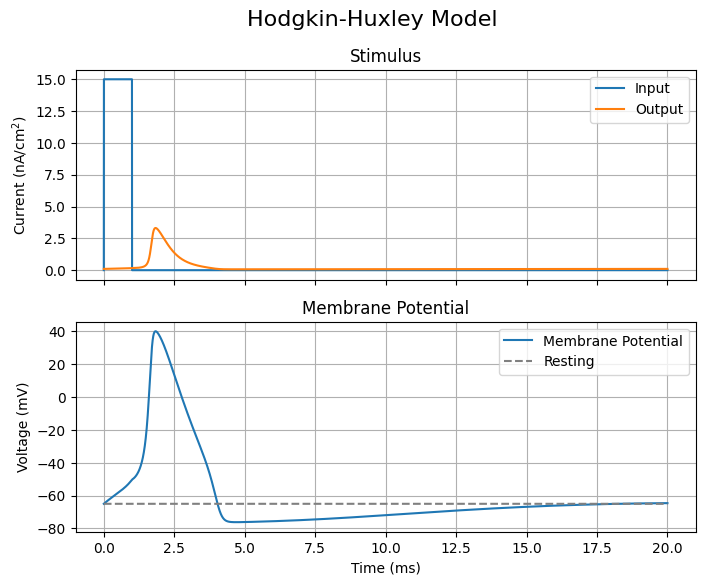

In [52]:
step = 0.001
t_end = 20
time = np.arange(0, t_end, step)

weight = 0.1
tau = 30

I_inp = np.where((np.arange(len(time)) > 0) & (np.arange(len(time)) < int(1.0/step)), 15.0, 0)
V_record = []
I_out = np.zeros(len(time))

neuron = HodgkinHuxleyNeuron(step)

for i in range(len(time)):
    neuron.step(I_inp[i])
    V_record.append(neuron.V)
    I_out[i] = weight * np.exp(-(-65.0 - neuron.V) / tau)



# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[1].plot(time, V_record, label='Membrane Potential')
axes[1].plot(time, np.full(len(time), -65), linestyle='--', color='gray', label='Resting')
axes[1].set_title('Membrane Potential')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (mV)')
axes[1].grid()
axes[1].legend()
axes[0].plot(time, I_inp, label='Input')
axes[0].plot(time, I_out, label='Output')
axes[0].set_title('Stimulus')
axes[0].set_ylabel('Current (nA/cm$^2$)')
axes[0].grid()
axes[0].legend()
fig.suptitle('Hodgkin-Huxley Model ', fontsize=16)
# fig.tight_layout()
plt.show()


##### Dynamics

In [53]:
def create_N_to_1(N, step):
    network = nx.DiGraph()
    network.add_nodes_from(range(N))

    for i in range(N - 1):
        network.add_edge(i, N - 1)

    for node in network.nodes():
        network.nodes[node]['neuron'] = HodgkinHuxleyNeuron(step)

    return network
    

def plot_network(network, ax):
    pos = nx.spring_layout(network)
    nx.draw_networkx(network, pos, node_size=500, node_color="lightblue", edge_color="gray", arrows=True, ax=ax)
    ax.set_title(f"{len(network.nodes) - 1} to 1 Network")
    ax.axis("off")
    plt.tight_layout()


def sim(network):
    V_record = {node: [] for node in network.nodes()}
    Network = network.nodes()
    
    for i in range(len(time)):
        for node in Network:
            neuron = Network[node]['neuron']
            I = 0.0

            if node in range(len(Network) - 1):
                neuron.step(I_inp[i])
                V_record[node].append(neuron.V)
            else:
                Vs = np.array([Network[pred]['neuron'].V for pred in list(network.predecessors(node))])
                I = sum(weight * np.exp(-(neuron.V - Vs) / tau))

                neuron.step(I)
                V_record[node].append(neuron.V)

    return V_record


def plot_sim(Time, Vs, ax):
    for node, V in Vs.items():
        ax.plot(Time, V, label=f'Neuron {node}')

    ax.plot(Time, np.full(len(Time), -65.0), linestyle='--', label='Resting', color='gray')  
    ax.set_title("Membrane Potential")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()
    ax.legend()

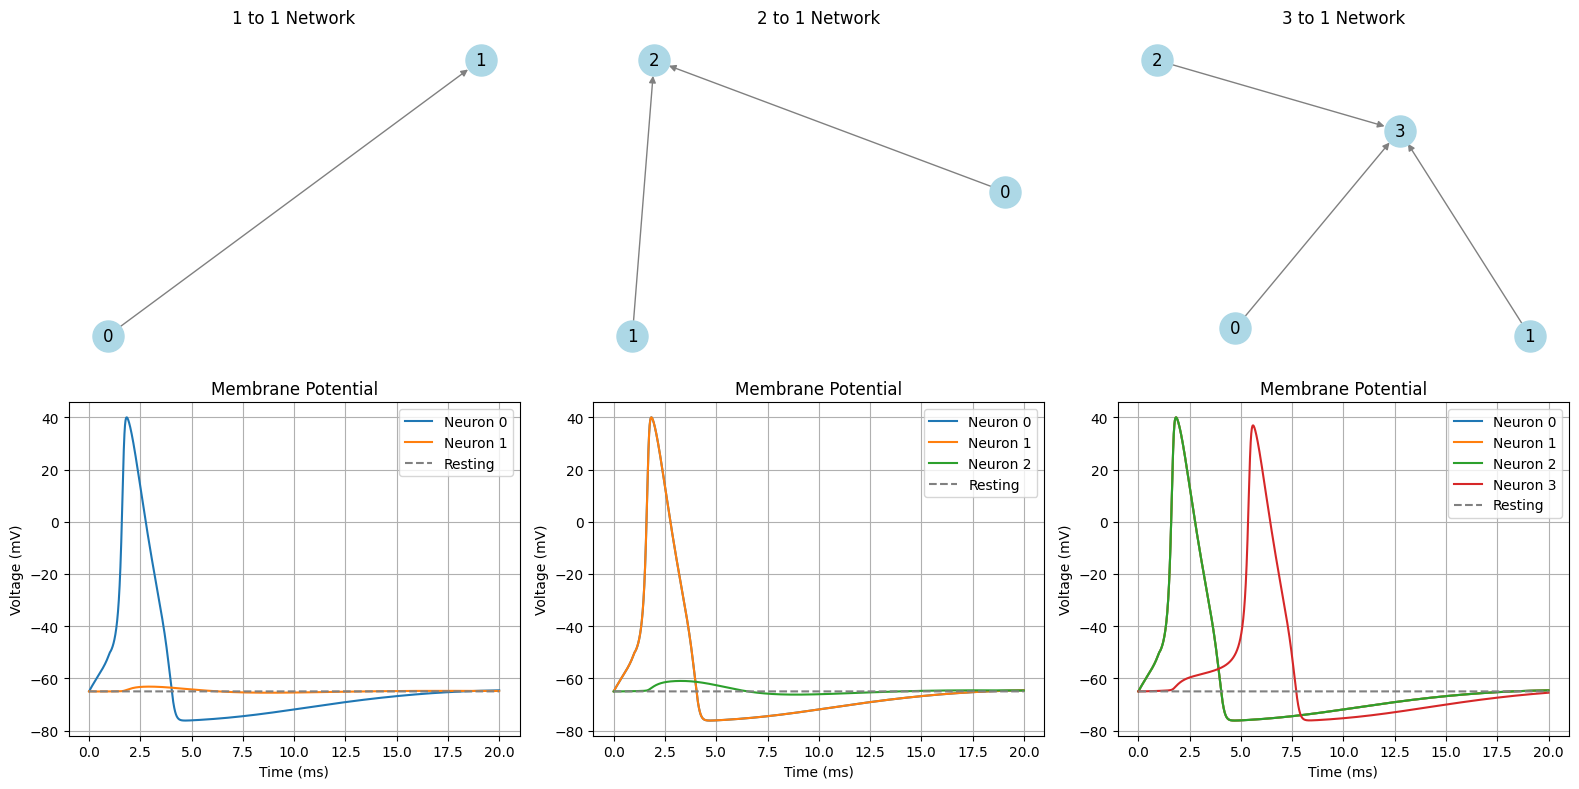

In [54]:
N = 3
step = 0.001
Nets = [create_N_to_1(i, step) for i in range(2, 2 + N)]
Vs_Nets = [sim(Net) for Net in Nets]


fig, axes = plt.subplots(2, N, figsize=(16, 8))
for i in range(N):
    plot_network(Nets[i], axes[0][i])
    plot_sim(time, Vs_Nets[i], axes[1][i])

### Network

##### Erdos-Renyi Directed Graph

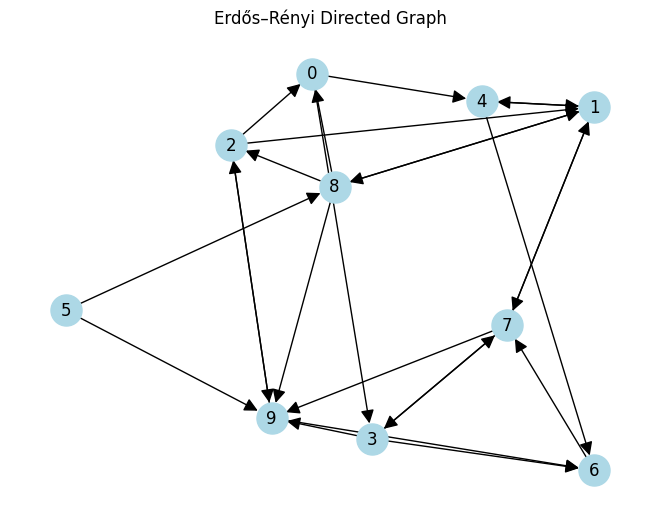

In [55]:
# Parameters
n = 10
p = 0.3

# Generate the graph
G = nx.erdos_renyi_graph(n, p, directed=True)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()

### Layered Network

#### Two Layers

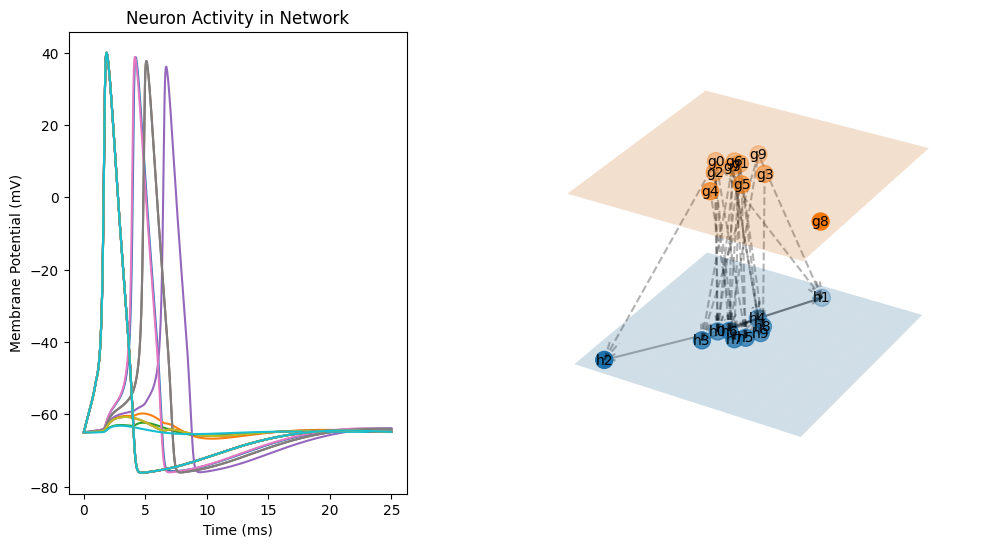

In [59]:
n = 10
p = 0.3
prob_inter = 0.2
time = 25
step = 0.01

Network = LayeredNetworkGraph([(n, p, 'g'), (n, p, 'h')], time, step, inter_prob=prob_inter, verbose=True)
peaktime = Network.run()g

##### Simulation

In [57]:
n = 20
step = 0.01
time = 25
step = 0.01
N_sim = 20

intra_p = 0.3
inter_ps = np.arange(0, 1 + step, step)


def layered_sim(p):
    Network = LayeredNetworkGraph([(n, 0, 'g'), (n, intra_p, 'h')], time, step, inter_prob=p, verbose=False)
    return Network.run()


with Pool(processes=4) as pool:
    peak_times = pool.map(layered_sim, inter_ps)


##### Analysis

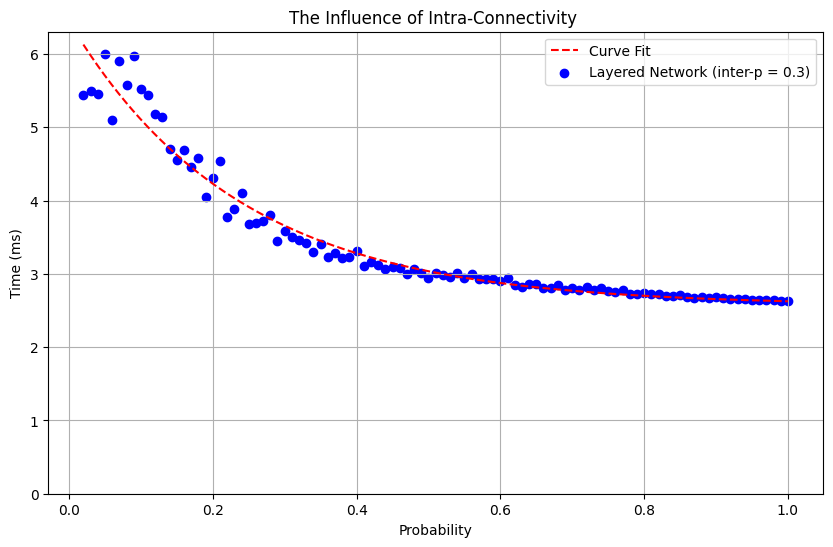

In [58]:
# Exponential Decay
def fit_function(x, a, b, c):
    return a * np.exp(-b * x) + c

# Filter Zeros
idxs = np.array(peak_times) != 0  # Create a mask for non-zero values
f_ps = inter_ps[idxs]
f_times = np.array(peak_times)[idxs]

# Curve Fit
popt, pcov = curve_fit(fit_function, f_ps, f_times)
fit_x = np.linspace(min(f_ps), max(f_ps), 500)
fit_y = fit_function(fit_x, *popt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(f_ps, f_times, label=f"Layered Network (inter-p = {intra_p})", color="blue")
plt.plot(fit_x, fit_y, label="Curve Fit", color="red", linestyle="--")
plt.xlabel("Probability")
plt.ylabel("Time (ms)")
plt.ylim(bottom=0)
plt.legend()
plt.title(f"The Influence of Intra-Connectivity ")
plt.grid()
plt.show()

###